<a href="https://colab.research.google.com/github/AxithChoudhary/Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open("/content/drive/MyDrive/Upgrad dataset/complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [4]:

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
df.isna().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [7]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:

import re
#Assign new column names
df.columns=[re.sub('^_','',col) for col in df.columns]

df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [9]:
#Assign nan in place of blanks in the complaints column
df.columns
df["complaint_what_happened"].replace("",np.nan,inplace=True)

In [10]:
df["complaint_what_happened"]

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [11]:
#Remove all rows where complaints column is nan
df.dropna(subset=["complaint_what_happened"],inplace=True)

In [12]:
df["complaint_what_happened"]

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [13]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanText(text):
    text=text.lower()
    text=re.sub(r'\[.*?\]','',text)

    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: cleanText(x))

In [15]:
import nltk
nltk.download("popular")
# pip install nltk

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [16]:

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemma_texts(document):     
    lemmaList = []
    # document = nlp(document)
    lemmaList.append(lemmatizer.lemmatize(document))
    # for word in document:
    #     lemmaList.append(lemmatizer.lemmatize(word))
    return " ".join(lemmaList)

df["lemmatized_complaint"] =  df['complaint_what_happened'].apply(lambda x: lemma_texts(x))
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...


In [17]:
df["lemmatized_complaint"].head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in xx/xx/ and was...
10    chase card was reported on xx/xx/. however, fr...
11    on xx/xx/, while trying to book a xxxx  xxxx  ...
14    my grand son give me check for {$.} i deposit ...
Name: lemmatized_complaint, dtype: object

In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]

In [19]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,"chase card was reported on xx/xx/. however, fr...","chase card was reported on xx/xx/. however, fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx/xx/, while trying to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give me check for {$.} i deposit ...


In [20]:
#Write your function to extract the POS tags 
from textblob import TextBlob

def pos_tag(text):
  # write your code here
    text_blob = TextBlob(text)

    return ' '.join([ word for (word,pos) in text_blob.tags if pos == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


<ipython-input-20-c5cc069ed390>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
df_clean.columns

Index(['complaint_what_happened', 'lemmatized_complaint',
       'complaint_POS_removed'],
      dtype='object')

In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...
10,"chase card was reported on xx/xx/. however, fr...","chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...


In [23]:
df_clean.columns

Index(['complaint_what_happened', 'lemmatized_complaint',
       'complaint_POS_removed'],
      dtype='object')

In [24]:
df_clean.shape

(21072, 3)

In [25]:
# df.to_csv('df.csv')
# df_clean.to_csv('df_clean.csv')
# !cp df.csv "/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification"
# !cp df_clean.csv "/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification"

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [26]:
# import json 
# import numpy as np
# import pandas as pd
# import re, nltk, spacy, string
# import en_core_web_sm
# nlp = en_core_web_sm.load()
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# from plotly.offline import plot
# import plotly.graph_objects as go
# import plotly.express as px

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from pprint import pprint

# from google.colab import drive
# drive.mount('/content/drive')

# df=pd.read_csv("/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification/df.csv")
# df.head()

# df_clean=pd.read_csv("/content/drive/MyDrive/Upgrad dataset/Automatic Ticket Classification/df_clean.csv")
# df_clean.head()

In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len=[len(word) for word in df_clean["complaint_what_happened"]]
print(complaint_len[:10])

[482, 351, 220, 1470, 466, 29, 2265, 1392, 3528, 129]


Text(0, 0.5, 'No. of Complaints')

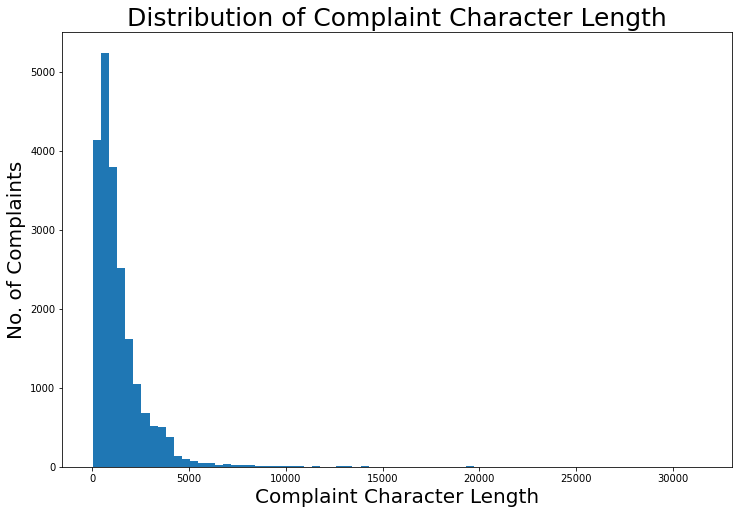

In [28]:
plt.figure(figsize=(12,8))
plt.hist(complaint_len,bins=75)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

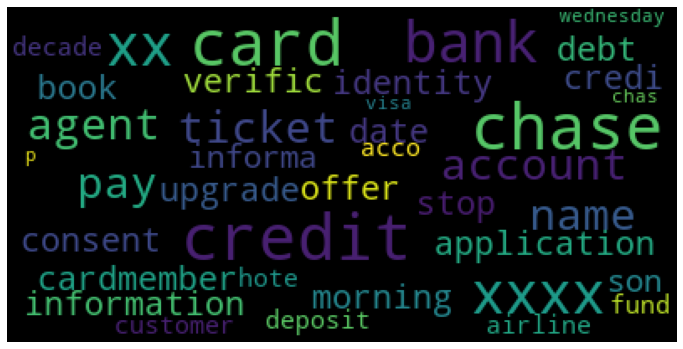

In [29]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS

stop_word=set(STOPWORDS)
word_cloud=WordCloud(
                          stopwords=stop_word,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42).generate(str(df_clean["complaint_POS_removed"]))

fig=plt.figure(figsize=(12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


In [30]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-30-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
df_clean["complaint_POS_removed"].head()

1     morning name stop bank cardmember debt verific...
2     i card agent upgrade date agent information or...
10    card xx/xx/ application identity consent credi...
11    book xxxx ticket i offer ticket card i informa...
14    son deposit chase account fund chase bank acco...
Name: complaint_POS_removed, dtype: object

In [32]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def n_gram(text,n=1,type="unigram",top=30):
  countVector=CountVectorizer(stop_words='english',ngram_range=(n,n)).fit(text)
  ngram=countVector.transform(text)
  count_values=ngram.sum(axis=0)
  vocab=[(word,count_values[0,idx]) for word,idx in countVector.vocabulary_.items()]
  df_ngram=pd.DataFrame(sorted(vocab,key=lambda x: x[1],reverse=True)).rename(columns={0:"frequence",1:type})
  return df_ngram[:top]



In [33]:
#Print the top 10 words in the unigram frequency
top_unigram_word=n_gram(df_clean["complaint_POS_removed"].values.astype('U'))
top_unigram_word.head(10)

,frequence,unigram
0,xxxx,63330
1,chase,54904
2,account,41446
3,xx,38614
4,credit,32743
5,bank,26710
6,card,26321
7,payment,14017
8,time,12021
9,money,11969


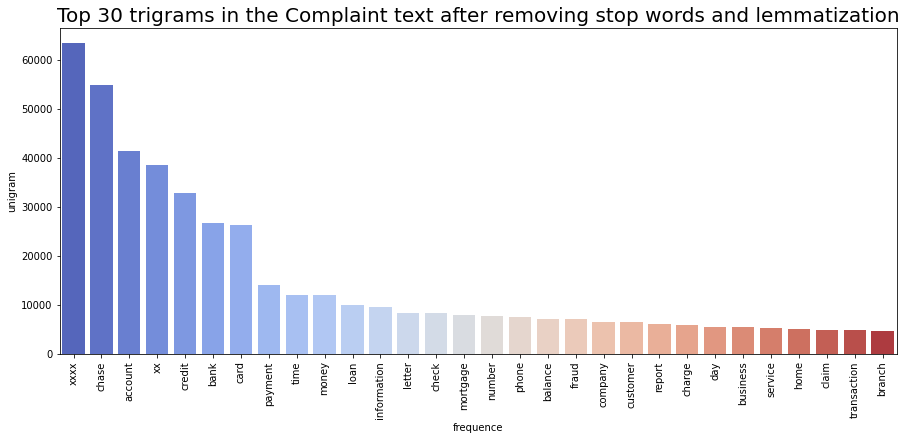

In [34]:

plt.figure(figsize=(15,6))
sns.barplot(x='frequence', y='unigram', data=top_unigram_word, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_bigram_word=n_gram(df_clean["complaint_POS_removed"].values.astype('U'),2,"bigram")
top_bigram_word.head(30)

,frequence,bigram
0,xx xx,19277
1,xx xxxx,14155
2,credit card,11090
3,xxxx xxxx,10305
4,xxxx chase,3672
5,chase credit,3618
6,credit report,3281
7,chase account,3245
8,customer service,3026
9,account chase,3013


In [36]:
#Print the top 10 words in the bigram frequency
top_bigram_word.head(10)

,frequence,bigram
0,xx xx,19277
1,xx xxxx,14155
2,credit card,11090
3,xxxx xxxx,10305
4,xxxx chase,3672
5,chase credit,3618
6,credit report,3281
7,chase account,3245
8,customer service,3026
9,account chase,3013


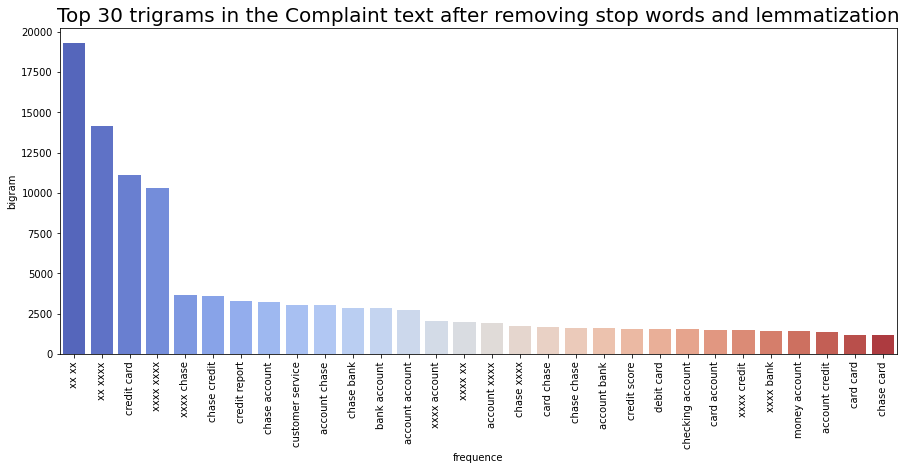

In [37]:
plt.figure(figsize=(15,6))
sns.barplot(x='frequence', y='bigram', data=top_bigram_word, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [38]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_trigram_word=n_gram(df_clean["complaint_POS_removed"].values.astype('U'),3,"trigram")
top_trigram_word.head(30)

,frequence,trigram
0,xx xx xxxx,13868
1,xxxx xxxx xxxx,2425
2,chase credit card,1998
3,xxxx xx xx,1961
4,xx xxxx chase,1140
5,account xx xx,1111
6,xx xxxx xx,863
7,credit card account,845
8,credit card company,819
9,chase xx xx,806


In [39]:
#Print the top 10 words in the trigram frequency
top_trigram_word.head(10)

,frequence,trigram
0,xx xx xxxx,13868
1,xxxx xxxx xxxx,2425
2,chase credit card,1998
3,xxxx xx xx,1961
4,xx xxxx chase,1140
5,account xx xx,1111
6,xx xxxx xx,863
7,credit card account,845
8,credit card company,819
9,chase xx xx,806


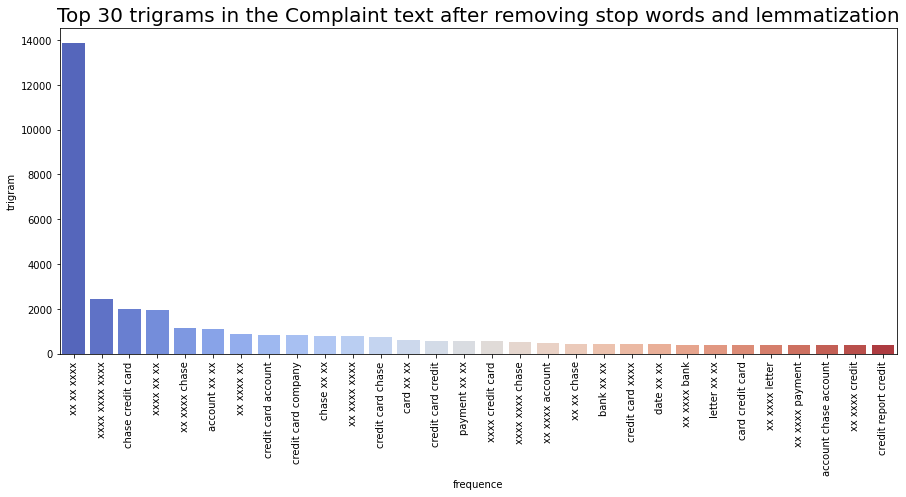

In [40]:
plt.figure(figsize=(15,6))
sns.barplot(x='frequence', y='trigram', data=top_trigram_word, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [41]:
df_clean['Complaint_clean'] = df_clean["complaint_POS_removed"].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean["complaint_POS_removed"].str.replace('xx','')

<ipython-input-41-af4d45983774>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-af4d45983774>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:

#Print the top 10 words in the unigram frequency
top_unigram_word=n_gram(df_clean['Complaint_clean'].values.astype('U'))
top_unigram_word.head(10)


,frequence,unigram
0,chase,54921
1,account,41448
2,credit,32747
3,bank,26714
4,card,26323
5,payment,14018
6,time,12021
7,money,11969
8,loan,10039
9,information,9661


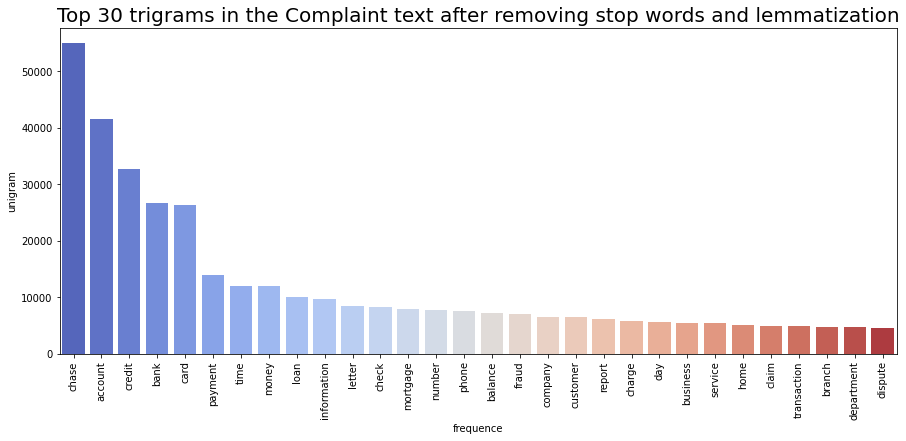

In [43]:
plt.figure(figsize=(15,6))
sns.barplot(x='frequence', y='unigram', data=top_unigram_word, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [44]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_bigram_word=n_gram(df_clean['Complaint_clean'].values.astype('U'),2,"bigram")
top_bigram_word.head(30)



,frequence,bigram
0,credit card,11108
1,chase credit,3727
2,chase account,3354
3,credit report,3289
4,account chase,3289
5,account account,3030
6,customer service,3026
7,bank account,2927
8,chase bank,2907
9,chase chase,1875


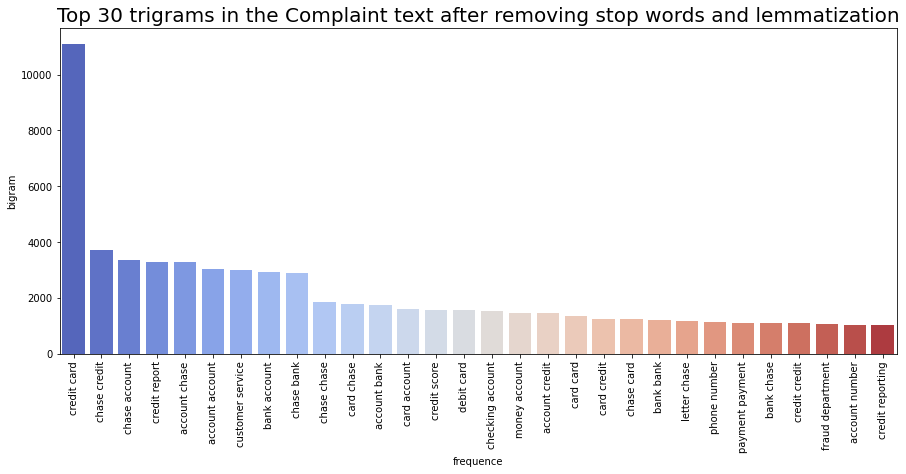

In [45]:
plt.figure(figsize=(15,6))
sns.barplot(x='frequence', y='bigram', data=top_bigram_word, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [46]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_trigram_word=n_gram(df_clean['Complaint_clean'].values.astype('U'),3,"trigram")
top_trigram_word.head(30)

,frequence,trigram
0,chase credit card,2047
1,credit card account,877
2,credit card company,824
3,credit card chase,817
4,credit card credit,645
5,card credit card,451
6,account chase account,423
7,bank credit card,386
8,credit report credit,380
9,credit card bank,356


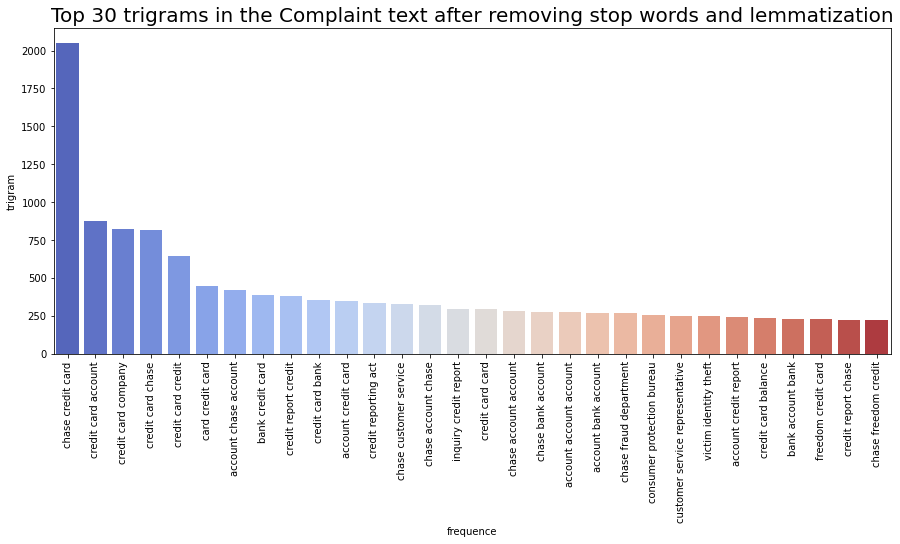

In [47]:
plt.figure(figsize=(15,6))
sns.barplot(x='frequence', y='trigram', data=top_trigram_word, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

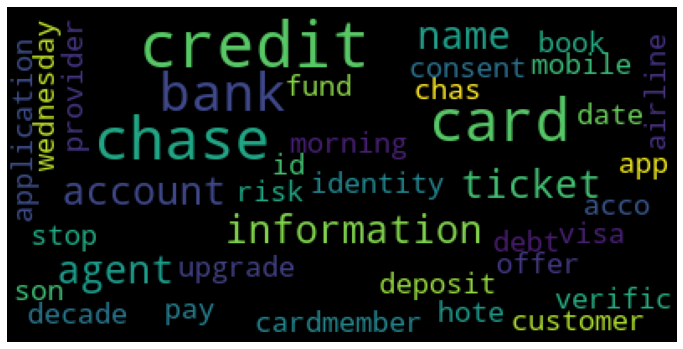

In [48]:
from wordcloud import WordCloud,STOPWORDS

stop_word=set(STOPWORDS)
word_cloud=WordCloud(
                          stopwords=stop_word,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42).generate(str(df_clean['Complaint_clean']))

fig=plt.figure(figsize=(12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [49]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
10,"chase card was reported on xx/xx/. however, fr...","chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...,card // application identity consent credit id...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...
14,my grand son give me check for {$.} i deposit ...,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade credit airline hote...,chase card customer decade credit airline hote...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday, xx/xx/xxxx i called chas, my xxx...",wednesday xx/xx/xxxx i chas visa credit card p...,wednesday // i chas visa credit card provider ...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk bank app chase mobile banking i mer...,i pay risk bank app chase mobile banking i mer...
78311,i have had flawless credit for yrs. i've had ...,i have had flawless credit for yrs. i've had ...,i credit yrs i credit chase freedom xxxx i bal...,i credit yrs i credit chase freedom i balance...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [50]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_df=0.95, min_df=2,stop_words="english")


In [51]:
df_clean['Complaint_clean']

1        morning name stop bank cardmember debt verific...
2        i card agent upgrade date agent information or...
10       card // application identity consent credit id...
11       book  ticket i offer ticket card i information...
14       son deposit chase account fund chase bank acco...
                               ...                        
78303    chase card customer decade credit airline hote...
78309    wednesday // i chas visa credit card provider ...
78310    i pay risk bank app chase mobile banking i mer...
78311    i credit yrs i credit chase freedom  i balance...
78312    jp bank  order line credit i i account payment...
Name: Complaint_clean, Length: 21072, dtype: object

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [52]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidfMat=tfidf.fit_transform(df_clean.Complaint_clean.values.astype("U"))

In [53]:
tfidfMat.getnnz()

504792

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [54]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [55]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
10,"chase card was reported on xx/xx/. however, fr...","chase card was reported on xx/xx/. however, fr...",card xx/xx/ application identity consent credi...,card // application identity consent credit id...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx/xx/, while trying to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...
14,my grand son give me check for {$.} i deposit ...,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade credit airline hote...,chase card customer decade credit airline hote...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday, xx/xx/xxxx i called chas, my xxx...",wednesday xx/xx/xxxx i chas visa credit card p...,wednesday // i chas visa credit card provider ...
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk bank app chase mobile banking i mer...,i pay risk bank app chase mobile banking i mer...
78311,i have had flawless credit for yrs. i've had ...,i have had flawless credit for yrs. i've had ...,i credit yrs i credit chase freedom xxxx i bal...,i credit yrs i credit chase freedom i balance...


In [56]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model =NMF(n_components=num_topics,random_state=40) #write your code here


In [57]:
nmf_model.fit(tfidfMat)
print(len(tfidf.get_feature_names()))

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



6590


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [58]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC {index + 1}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC 1
['information', 'day', 'claim', 'transaction', 'fraud', 'business', 'checking', 'number', 'deposit', 'branch', 'chase', 'check', 'money', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC 2
['phone', 'letter', 'service', 'time', 'balance', 'purchase', 'fee', 'merchant', 'company', 'dispute', 'fraud', 'charge', 'credit', 'chase', 'card']


THE TOP 15 WORDS FOR TOPIC 3
['process', 'information', 'bank', 'sale', 'time', 'rate', 'letter', 'house', 'foreclosure', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']


THE TOP 15 WORDS FOR TOPIC 4
['bureau', 'history', 'company', 'theft', 'identity', 'limit', 'bureaus', 'information', 'account', 'reporting', 'debt', 'score', 'inquiry', 'report', 'credit']


THE TOP 15 WORDS FOR TOPIC 5
['history', 'car', 'pay', 'error', 'day', 'account', 'chase', 'time', 'date', 'auto', 'fee', 'statement', 'month', 'balance', 'payment']




In [59]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(tfidfMat)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 3, ..., 1, 4, 4])

In [60]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis = 1) # write your code to assign topics to each rows.

<ipython-input-60-3027202da87d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
#Print the first 5 Complaint for each of the Topics
df_clean5=df_clean.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
24,mishandling of this account by chase auto and ...,mishandling of this account by chase auto and ...,mishandling account auto xxxx,mishandling account auto,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p. morgan chase restricted m...,j.p. chase account debit card tuesday i branch...,j.p. chase account debit card tuesday i branch...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give me check for {$.} i deposit ...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0
27,i opened an account with chase bank on xxxx an...,i opened an account with chase bank on xxxx an...,i account bank xxxx code bonus i everything ac...,i account bank code bonus i everything accoun...,0
40,"xxxx xxxx a sofa, love seat, table and chairs ...","xxxx xxxx a sofa, love seat, table and chairs ...",xxxx sofa seat table debit card bank claim fur...,sofa seat table debit card bank claim furnitu...,1
21,"on xxxx xx/xx/, i made a {$.} payment to an on...","on xxxx xx/xx/, i made a {$.} payment to an on...",i payment retailer pay xxxx chase website i we...,i payment retailer pay chase website i websit...,1
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,i upgraded my xxxx xxxx card in xx/xx/ and was...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,chase card catering order i amount i chase tod...,chase card catering order i amount i chase tod...,1
48,"jp morgan chase bank, please answer the follow...","jp morgan chase bank, please answer the follow...",jp bank chase information reason information c...,jp bank chase information reason information c...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [62]:
#Create the dictionary of Topic names and Topics
topic={0:"Other",1.0:"Theft/Dispute Reporting",2.0:"Bank Account services",3.0:"Mortgage/Loan",4.0:"Credit card or prepaid card"}
df_clean['Topic'] =df_clean['Topic'].map(topic) 

<ipython-input-62-443bd219440f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [69]:
# Create the dictionary again of Topic names and Topics
Topic_names = {"Other":0,"Theft/Dispute Reporting":1,"Bank Account services":2,"Mortgage/Loan":3,"Credit card or prepaid card":4}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-69-c4b74c868fe3>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
df_clean[["Topic","Complaint_clean"]]

,Topic,Complaint_clean
1,0,morning name stop bank cardmember debt verific...
2,1,i card agent upgrade date agent information or...
10,3,card // application identity consent credit id...
11,3,book ticket i offer ticket card i information...
14,0,son deposit chase account fund chase bank acco...
...,...,...
78303,3,chase card customer decade credit airline hote...
78309,1,wednesday // i chas visa credit card provider ...
78310,1,i pay risk bank app chase mobile banking i mer...
78311,4,i credit yrs i credit chase freedom i balance...


In [72]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [73]:
# Write your code to get the Vector count
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [74]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,1
10,"chase card was reported on xx/xx/. however, fr...",3
11,"on xx/xx/, while trying to book a xxxx xxxx ...",3
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,after being a chase card customer for well ove...,3
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",1
78310,i am not familiar with xxxx pay and did not un...,1
78311,i have had flawless credit for yrs. i've had ...,4


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [75]:
from sklearn.model_selection import train_test_split

# Performing Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train:\033[1m {X_train.shape}", '\033[0m')
print(f"Shape of y_train:\033[1m {y_train.shape}", '\033[0m')
print(f"Shape of X_test:\033[1m {X_test.shape}", '\033[0m')
print(f"Shape of y_test:\033[1m {y_test.shape}", '\033[0m')

Shape of X_train: (15804, 27984) 
Shape of y_train: (15804,) 
Shape of X_test: (5268, 27984) 
Shape of y_test: (5268,) 


##Logistic regression

In [77]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix,accuracy_score

ss=StandardScaler()
from sklearn.linear_model import LogisticRegression 
lr=LogisticRegression()
lr.fit(X_train,y_train)
lpredict=lr.predict(X_test)


print ("Accuracy : ", accuracy_score(y_test, lpredict))
f1_lr = f1_score(y_test, lpredict, average="weighted")
print("the F1 score is",f1_lr)



Accuracy :  0.9265375854214123
the F1 score is 0.9260589879920755


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



##Decision Tree

In [78]:
from sklearn.tree import DecisionTreeClassifier
dc=DecisionTreeClassifier().fit(X_train,y_train)
dpredict=dc.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test, dpredict))
f1_lr = f1_score(y_test, dpredict, average="weighted")
print("the F1 score is",f1_lr)


Accuracy :  0.821753986332574
the F1 score is 0.8215051523806834


##Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth=5)
rfm=rf.fit(X_train,y_train)
rfpredict=rf.predict(X_test)

print ("Accuracy : ", accuracy_score(y_test, rfpredict))
f1_lr = f1_score(y_test, rfpredict, average="weighted")
print("the F1 score is",f1_lr)

Accuracy :  0.5816249050873197
the F1 score is 0.49588431160609764


##Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train.toarray(), y_train)
npredict = nb.predict(X_test.toarray())

print ("Accuracy : ", accuracy_score(y_test, npredict))
f1_lr = f1_score(y_test, npredict, average="weighted")
print("the F1 score is",f1_lr)

Accuracy :  0.3851556567957479
the F1 score is 0.39173503145761646


The Accuracy of different models are 

*   Logistic regression 92.6%
*  Decision Tree 82.02%
* Random Forest 59.83%
*  Naive Bayes 38.53%

